In [16]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
from ete3 import Tree
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import seaborn as sns
import matplotlib.pyplot as plt
import os

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [70]:
do_weighted = True

max_missing_threshold = 0.5
min_classified_threshold = 5
min_poly_threhold = 0
min_di_threshold = 0
min_plants = 6
min_pollinators = 6

relevant_features = ["partner.diversity", # shanon diversity
                     "d", # speciality index d',
                     "normalised.degree",
                     "weighted.betweenness", # centrality,
                     "weighted.closeness",
                     "hubbiness_score"]  # generality
relevant_features += [f"standardized_{f}" for f in relevant_features]

allmb_tree_path = "../../../data/trees/families_mrca_based_tree.nwk"
networks_dir = "../../../data/networks/all/"
species_features_paths = {"binary": "../../../data/features/plant/binary/features_with_classification.csv",
                          "binarized_weighted": "../../../data/features/plant/binarized_weighted/features_with_classification.csv",
                          "weighted": "../../../data/features/plant/weighted/features_with_classification.csv"}

classification_path = "../../../data/ploidy_classification/plant_classification.csv"
ploidb_path = "../../../data/ploidy_classification/ploidb_by_genus_without_missing.csv"

taxonomic_data_path = "../../../data/features/taxonomic_features/net_to_pollinators_taxonomic_classification.csv"
networks_metadata_path = "../../../data/networks/networks_metadata.csv"
plant_trait_db_path = "../../../data/plant_traits_db.csv"
ccdb_path = "/groups/itay_mayrose/halabikeren/PloiDB/ccdb_all_data_171122.csv"
species_mating_system_data_path_1 = "../../../data/metadata/species_level/mating_system_grossenbacher_2017.xlsx"
species_mating_system_data_path_2 = "../../../data/metadata/species_level/mating_system_ferguson_2109.tsv"

species_metadata_path_1 = "../../../data/metadata/species_level/plants_metadata_rice_2019.xlsx"
species_metadata_path_2 = "../../../data/metadata/species_level/LifeForm_Database.xlsx"
species_metadata_path_3 = "../../../data/metadata/species_level/PPN_spp-floral-traits_DATA-CHECK_8-4-23_NSS.xlsx"
lf_mapping_path= "../../../data/metadata/species_level/LifeFormMapping.xlsx"
lf_manual_classification_path = "../../../data/metadata/species_level/lf_manual_classification.csv"

processed_data_path = f"../../../data/statistical_analysis/species_level/processed_features_with_ploidy_classification_on_{'un' if not do_weighted else ''}weighted_networks.csv"
pre_processed_tree_path = f"../../../data/statistical_analysis/species_level/unique_species_tree_on_{'un' if not do_weighted else ''}weighted_networks.nwk"
processed_tree_path = f"../../../data/statistical_analysis/species_level/species_tree_on_{'un' if not do_weighted else ''}weighted_networks.nwk"
species_list_path = f"../../../data/statistical_analysis/species_level/species_list_{'un' if not do_weighted else ''}weighted_analysis.csv"

# process data

In [71]:
networks_metadata = pd.read_csv(networks_metadata_path)
networks_metadata["included_in_analysis"] = networks_metadata.apply(lambda rec: (rec.is_polyploid_missing_frac <= max_missing_threshold) and
                                                                             (rec.num_classified >= min_classified_threshold) and 
                                                                             (rec.num_polyploids >= min_poly_threhold) and 
                                                                             (rec.num_diploids >= min_di_threshold) and 
                                                                             (rec.num_plants >= min_plants) and 
                                                                             (rec.num_pollinators >= min_pollinators), axis=1)

In [72]:
allmb_tree = Tree(allmb_tree_path)
for leaf in allmb_tree.get_leaves():
    leaf.name = leaf.name.lower().replace("_", " ")

In [73]:
relevant_columns = ["Plant", "network_id"] + relevant_features
weighted_data = pd.read_csv(species_features_paths["weighted"])
weighted_data = weighted_data.rename(columns={c: c.replace("_y","") for c in weighted_data.columns if c.endswith("_y")})
weighted_data = weighted_data[relevant_columns]
weighted_data["network_type"] = "weighted"

binarized_weighted_data = pd.read_csv(species_features_paths["binarized_weighted"])
binarized_weighted_data = binarized_weighted_data.rename(columns={c: c.replace("_y","") for c in binarized_weighted_data.columns if c.endswith("_y")})
binarized_weighted_data = binarized_weighted_data[relevant_columns]
binarized_weighted_data["network_type"] = "binarized_weighted"

binary_data = pd.read_csv(species_features_paths["binary"])
binary_data = binary_data.rename(columns={c: c.replace("_y","") for c in binary_data.columns if c.endswith("_y")})
binary_data = binary_data[relevant_columns]
binary_data["network_type"] = "binary"  

features = pd.concat([weighted_data,binarized_weighted_data,binary_data]).rename(columns={"network_id": "network_index"})
features["original_name"] = features.Plant.str.lower()

features = features.merge(networks_metadata[["network_type", "network_index", "included_in_analysis"]], on=["network_type", "network_index"], how="left")

In [74]:
classification = pd.read_csv(classification_path).rename(columns={"polyploid_age": "ploidy_age"})
features_with_classification = features.merge(classification[["original_name", "resolved_name", "is_polyploid", "ploidy_age"]], on="original_name", how="left")
features_with_classification.set_index("original_name", inplace=True)
features_with_classification.reset_index(inplace=True)

In [75]:
features_with_classification.groupby("is_polyploid", dropna=False)["original_name"].count() / features_with_classification.shape[0]*100

is_polyploid
0.0    29.635532
1.0    25.735017
NaN    44.629451
Name: original_name, dtype: float64

In [77]:
clean_features_with_classification = features_with_classification.dropna(subset=relevant_features+["is_polyploid"], how="any", axis=0)

In [78]:
clean_features_with_classification.groupby("is_polyploid", dropna=False)["original_name"].count() / clean_features_with_classification.shape[0]*100

is_polyploid
0.0    53.519828
1.0    46.480172
Name: original_name, dtype: float64

In [79]:
print(f"# species from networks = {len(clean_features_with_classification.original_name.unique()):,}")
print(f"# species from networks included in the analysis = {len(clean_features_with_classification.loc[clean_features_with_classification.included_in_analysis == True].original_name.unique()):,}")
print(f"# species in tree = {len(allmb_tree.get_leaf_names()):,}")

# species from networks = 2,104
# species from networks included in the analysis = 1,767
# species in tree = 67,712


In [80]:
clean_features_with_classification = clean_features_with_classification.drop(["included_in_analysis"], axis=1)
print(f"# species from analyzed networks = {len(clean_features_with_classification.original_name.unique()):,}")

# species from analyzed networks = 2,104


In [81]:
if do_weighted:
    clean_features_with_classification = clean_features_with_classification.loc[clean_features_with_classification.network_type == "weighted"]
else:
    clean_features_with_classification = clean_features_with_classification.loc[clean_features_with_classification.network_type != "weighted"]

In [82]:
tree_names = set(allmb_tree.get_leaf_names())
final_features_with_classification = clean_features_with_classification.copy()
final_features_with_classification["mapped_name"] = final_features_with_classification.apply(lambda record: record.original_name if record.original_name in tree_names else record.resolved_name, axis=1)


limited_final_features_with_classification = final_features_with_classification.loc[final_features_with_classification.original_name.isin(tree_names) |
                                                                                    final_features_with_classification.resolved_name.isin(tree_names)]

print(f"# species from networks for analysis = {len(limited_final_features_with_classification.mapped_name.unique()):,}")

# species from networks for analysis = 1,273


In [83]:
pruned_allmb_tree = allmb_tree.copy()
pruned_allmb_tree.prune(limited_final_features_with_classification.mapped_name.unique().tolist(), preserve_branch_length=True)
print(f"# species in tree = {len(pruned_allmb_tree.get_leaf_names()):,}")

# species in tree = 1,273


In [84]:
final_features_with_classification["mapped_name"] = final_features_with_classification["mapped_name"].str.replace(" ", "_")
final_features_with_classification["sample_id"] = final_features_with_classification["mapped_name"] + "_" + final_features_with_classification["network_type"] + "_" + final_features_with_classification["network_index"].astype("str")
final_features_with_classification.sample_id = final_features_with_classification.sample_id.str.replace(" ", "_")

limited_final_features_with_classification["mapped_name"] = limited_final_features_with_classification["mapped_name"].str.replace(" ", "_")
limited_final_features_with_classification["sample_id"] = limited_final_features_with_classification["mapped_name"] + "_" + final_features_with_classification["network_type"] + "_" + final_features_with_classification["network_index"].astype("str")
limited_final_features_with_classification.sample_id = limited_final_features_with_classification.sample_id.str.replace(" ", "_")

/tmp/ipykernel_39262/626221634.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_final_features_with_classification["mapped_name"] = limited_final_features_with_classification["mapped_name"].str.replace(" ", "_")
/tmp/ipykernel_39262/626221634.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_final_features_with_classification["sample_id"] = limited_final_features_with_classification["mapped_name"] + "_" + final_features_with_classification["network_type"] + "_" + final_features_with_cla

In [85]:
for l in pruned_allmb_tree.get_leaves():
    l.name = l.name.replace(" ", "_")

In [86]:
pruned_allmb_tree.write(outfile=pre_processed_tree_path, format=5)

In [87]:
final_features_with_classification = final_features_with_classification.drop_duplicates("sample_id")
limited_final_features_with_classification = limited_final_features_with_classification.drop_duplicates("sample_id")

In [88]:
assert(len(final_features_with_classification.sample_id.unique().tolist()) == final_features_with_classification.shape[0])

In [89]:
# add bushes under each leaf
num_added_nodes =0
tree_leaves = pruned_allmb_tree.get_leaves()
for leaf in tree_leaves:
    children_names = limited_final_features_with_classification.query(f"mapped_name == '{leaf.name}'").sample_id.tolist()
    leaf.dist = leaf.dist - 0.001
    assert(leaf.dist > 0)
    if len(children_names) > 0:
        for child_name in children_names:
            leaf.add_child(name=child_name, dist=0.001)
        num_added_nodes += len(children_names)
    else:
        print(f"no child for leaf {leaf.name}")
        leaf.dist = leaf.dist + 0
    
print(f"# added nodes = {num_added_nodes:,}")

# added nodes = 5,080


In [90]:
pruned_allmb_tree.prune(limited_final_features_with_classification.sample_id.dropna().unique().tolist(), preserve_branch_length=True)

In [91]:
print(f"# samples in data = {final_features_with_classification.shape[0]:,}")
print(f"# leaves in tree = {len(pruned_allmb_tree.get_leaf_names()):,}")

# samples in data = 5,331
# leaves in tree = 5,080


In [92]:
final_features_with_classification["network_id"] = final_features_with_classification.network_type.astype(str) + "_" + final_features_with_classification.network_index.astype(str)

/tmp/ipykernel_39262/3681789864.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_with_classification["network_id"] = final_features_with_classification.network_type.astype(str) + "_" + final_features_with_classification.network_index.astype(str)


In [93]:
print(f"# networks with plants in allmb = {len(limited_final_features_with_classification.network_index.unique()):,}")
print(f"# networks = {len(final_features_with_classification.network_index.unique()):,}")

# networks with plants in allmb = 645
# networks = 646


In [94]:
final_features_with_classification.to_csv(processed_data_path)
pruned_allmb_tree.write(outfile=processed_tree_path)

In [95]:
species = final_features_with_classification.mapped_name.str.replace("_"," ").unique()
pd.Series(species).to_csv(species_list_path)

# plot features distributions

In [19]:
final_features_with_classification = pd.read_csv(processed_data_path)

/tmp/ipykernel_39262/2551630152.py:1: DtypeWarning: Columns (4,33,40,73,88,92,107,122) have mixed types. Specify dtype option on import or set low_memory=False.
  final_features_with_classification = pd.read_csv(processed_data_path)


In [45]:
final_features_with_classification.is_polyploid = final_features_with_classification.is_polyploid.replace({1.0: "Polyploids", 0.0: "Diploids"})
features_by_ploidy = final_features_with_classification.groupby("is_polyploid")

/tmp/ipykernel_26920/1878803736.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)


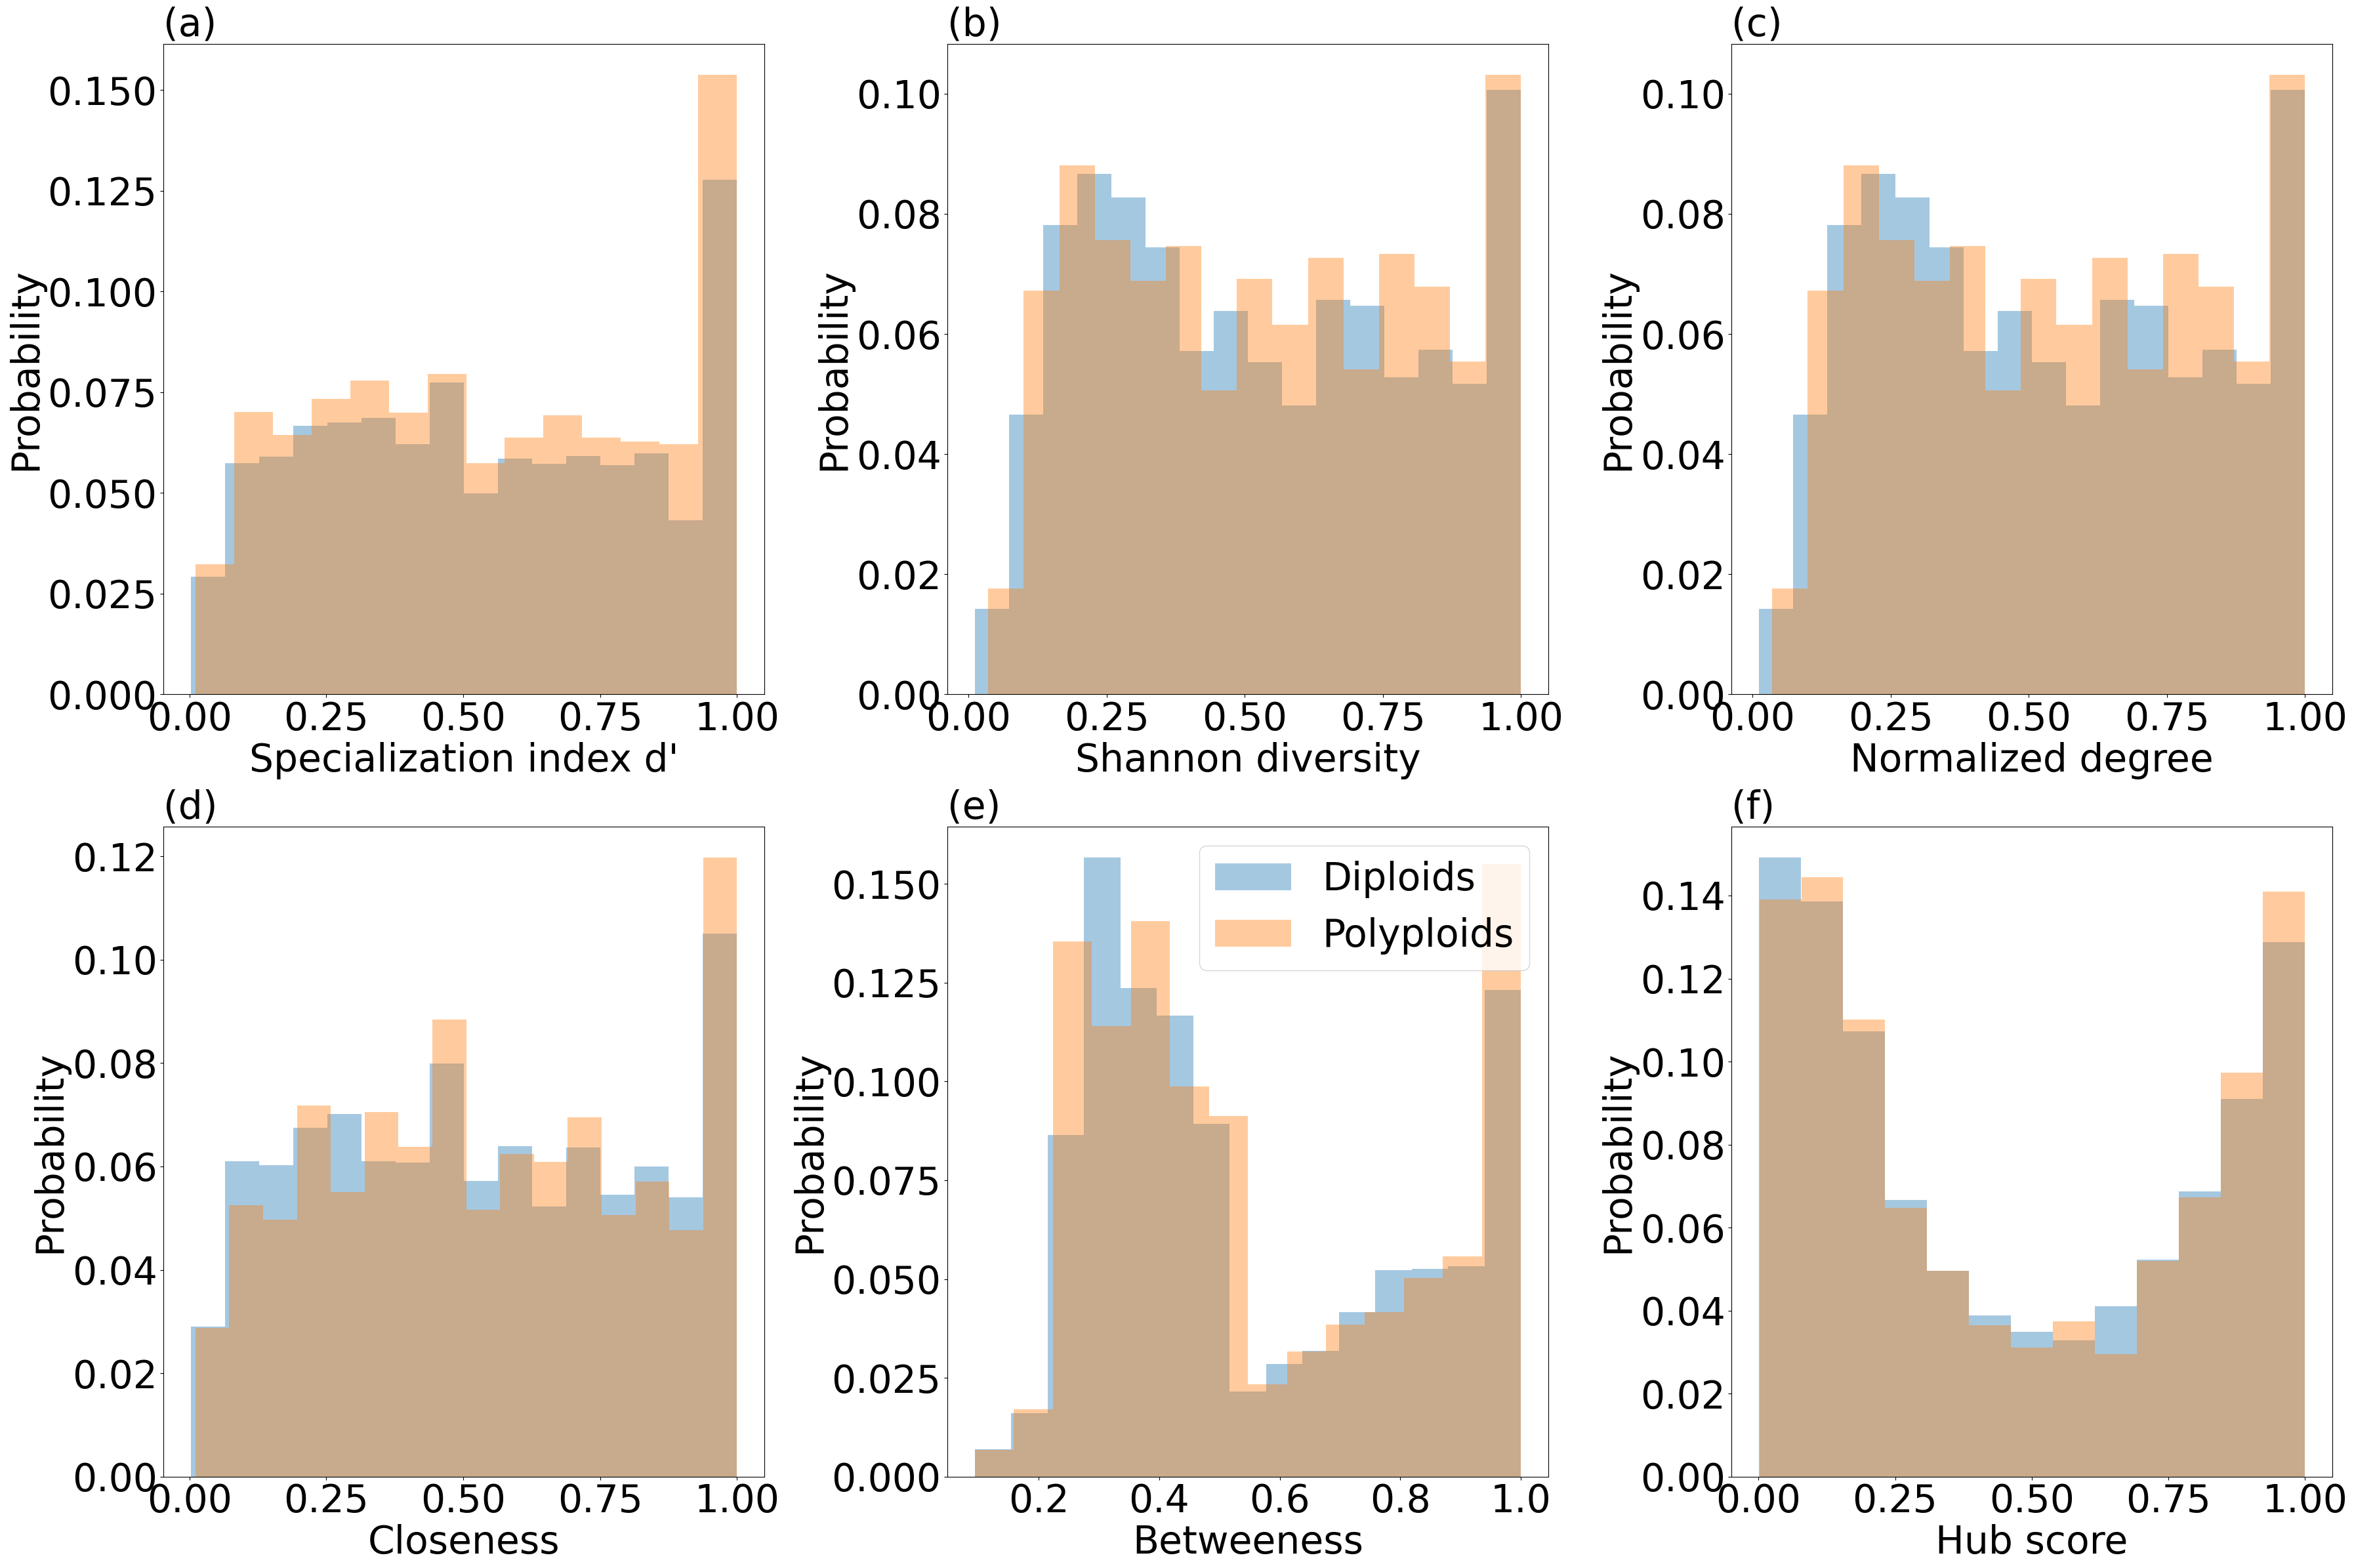

In [46]:
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42
poly_color = "tab:orange"
di_color = "tab:blue"
alpha = 0.4

fig, ax = plt.subplots(figsize=(3*12, 2*12))
# fig.suptitle(f"Indices distribution across {features_by_ploidy.get_group('Polyploids').shape[0]:,} polyploids and {features_by_ploidy.get_group('Diploids').shape[0]:,} diploids", fontsize=fontsize)

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=fig)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=fig)
ax4 = plt.subplot2grid((2,6), (1,0), colspan=2, fig=fig)
ax5 = plt.subplot2grid((2,6), (1,2), colspan=2, fig=fig)
ax6 = plt.subplot2grid((2,6), (1,4), colspan=2, fig=fig)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_d"], label="Diploids", color=di_color, ax=ax1, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_d"], label="Polyploids", ax=ax1, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax1.set_xlabel("Specialization index d'", fontsize=fontsize)
ax1.set_ylabel("Probability", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.tick_params(axis='both', which='minor', labelsize=fontsize)
ax1.set_title("(a)", loc="left", fontsize=fontsize)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_partner.diversity"], label="Diploids", color=di_color, ax=ax2, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_partner.diversity"], label="Polyploids", ax=ax2, color=poly_color, stat="probability",alpha=alpha, linewidth=0)
ax2.set_xlabel("Shannon diversity", fontsize=fontsize)
ax2.set_ylabel("Probability", fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize)
ax2.set_title("(b)", loc="left", fontsize=fontsize)


sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_normalised.degree"], label="Diploids", color=di_color, ax=ax3, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_normalised.degree"], label="Polyploids", ax=ax3, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax3.set_xlabel("Normalized degree", fontsize=fontsize)
ax3.set_ylabel("Probability", fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)
ax3.tick_params(axis='both', which='minor', labelsize=fontsize)
ax3.set_title("(c)", loc="left", fontsize=fontsize)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_weighted.closeness"], label="Diploids", color=di_color, ax=ax4, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_weighted.closeness"], label="Polyploids", ax=ax4, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax4.set_xlabel("Closeness", fontsize=fontsize)
ax4.set_ylabel("Probability", fontsize=fontsize)
ax4.tick_params(axis='both', which='major', labelsize=fontsize)
ax4.tick_params(axis='both', which='minor', labelsize=fontsize)
ax4.set_title("(d)", loc="left", fontsize=fontsize)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_weighted.betweenness"], label="Diploids", color=di_color, ax=ax5, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_weighted.betweenness"], label="Polyploids", ax=ax5, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax5.set_xlabel("Betweeness", fontsize=fontsize)
ax5.legend(prop={'size': fontsize})
ax5.set_ylabel("Probability", fontsize=fontsize)
ax5.tick_params(axis='both', which='major', labelsize=fontsize)
ax5.tick_params(axis='both', which='minor', labelsize=fontsize)
ax5.set_title("(e)", loc="left", fontsize=fontsize)


sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_hubbiness_score"], label="Diploids", color=di_color, ax=ax6, stat="probability", alpha=alpha, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_hubbiness_score"], label="Polyploids", ax=ax6, color=poly_color, stat="probability", alpha=alpha, linewidth=0)
ax6.set_xlabel("Hub score", fontsize=fontsize)
ax6.set_ylabel("Probability", fontsize=fontsize)
ax6.tick_params(axis='both', which='major', labelsize=fontsize)
ax6.tick_params(axis='both', which='minor', labelsize=fontsize)
ax6.set_title("(f)", loc="left", fontsize=fontsize)

fig.tight_layout()
fig.savefig(f"../../../data/figures/fig1_{'weighted' if do_weighted else 'binary'}.jpeg")

/tmp/ipykernel_26920/1359977466.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)
/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


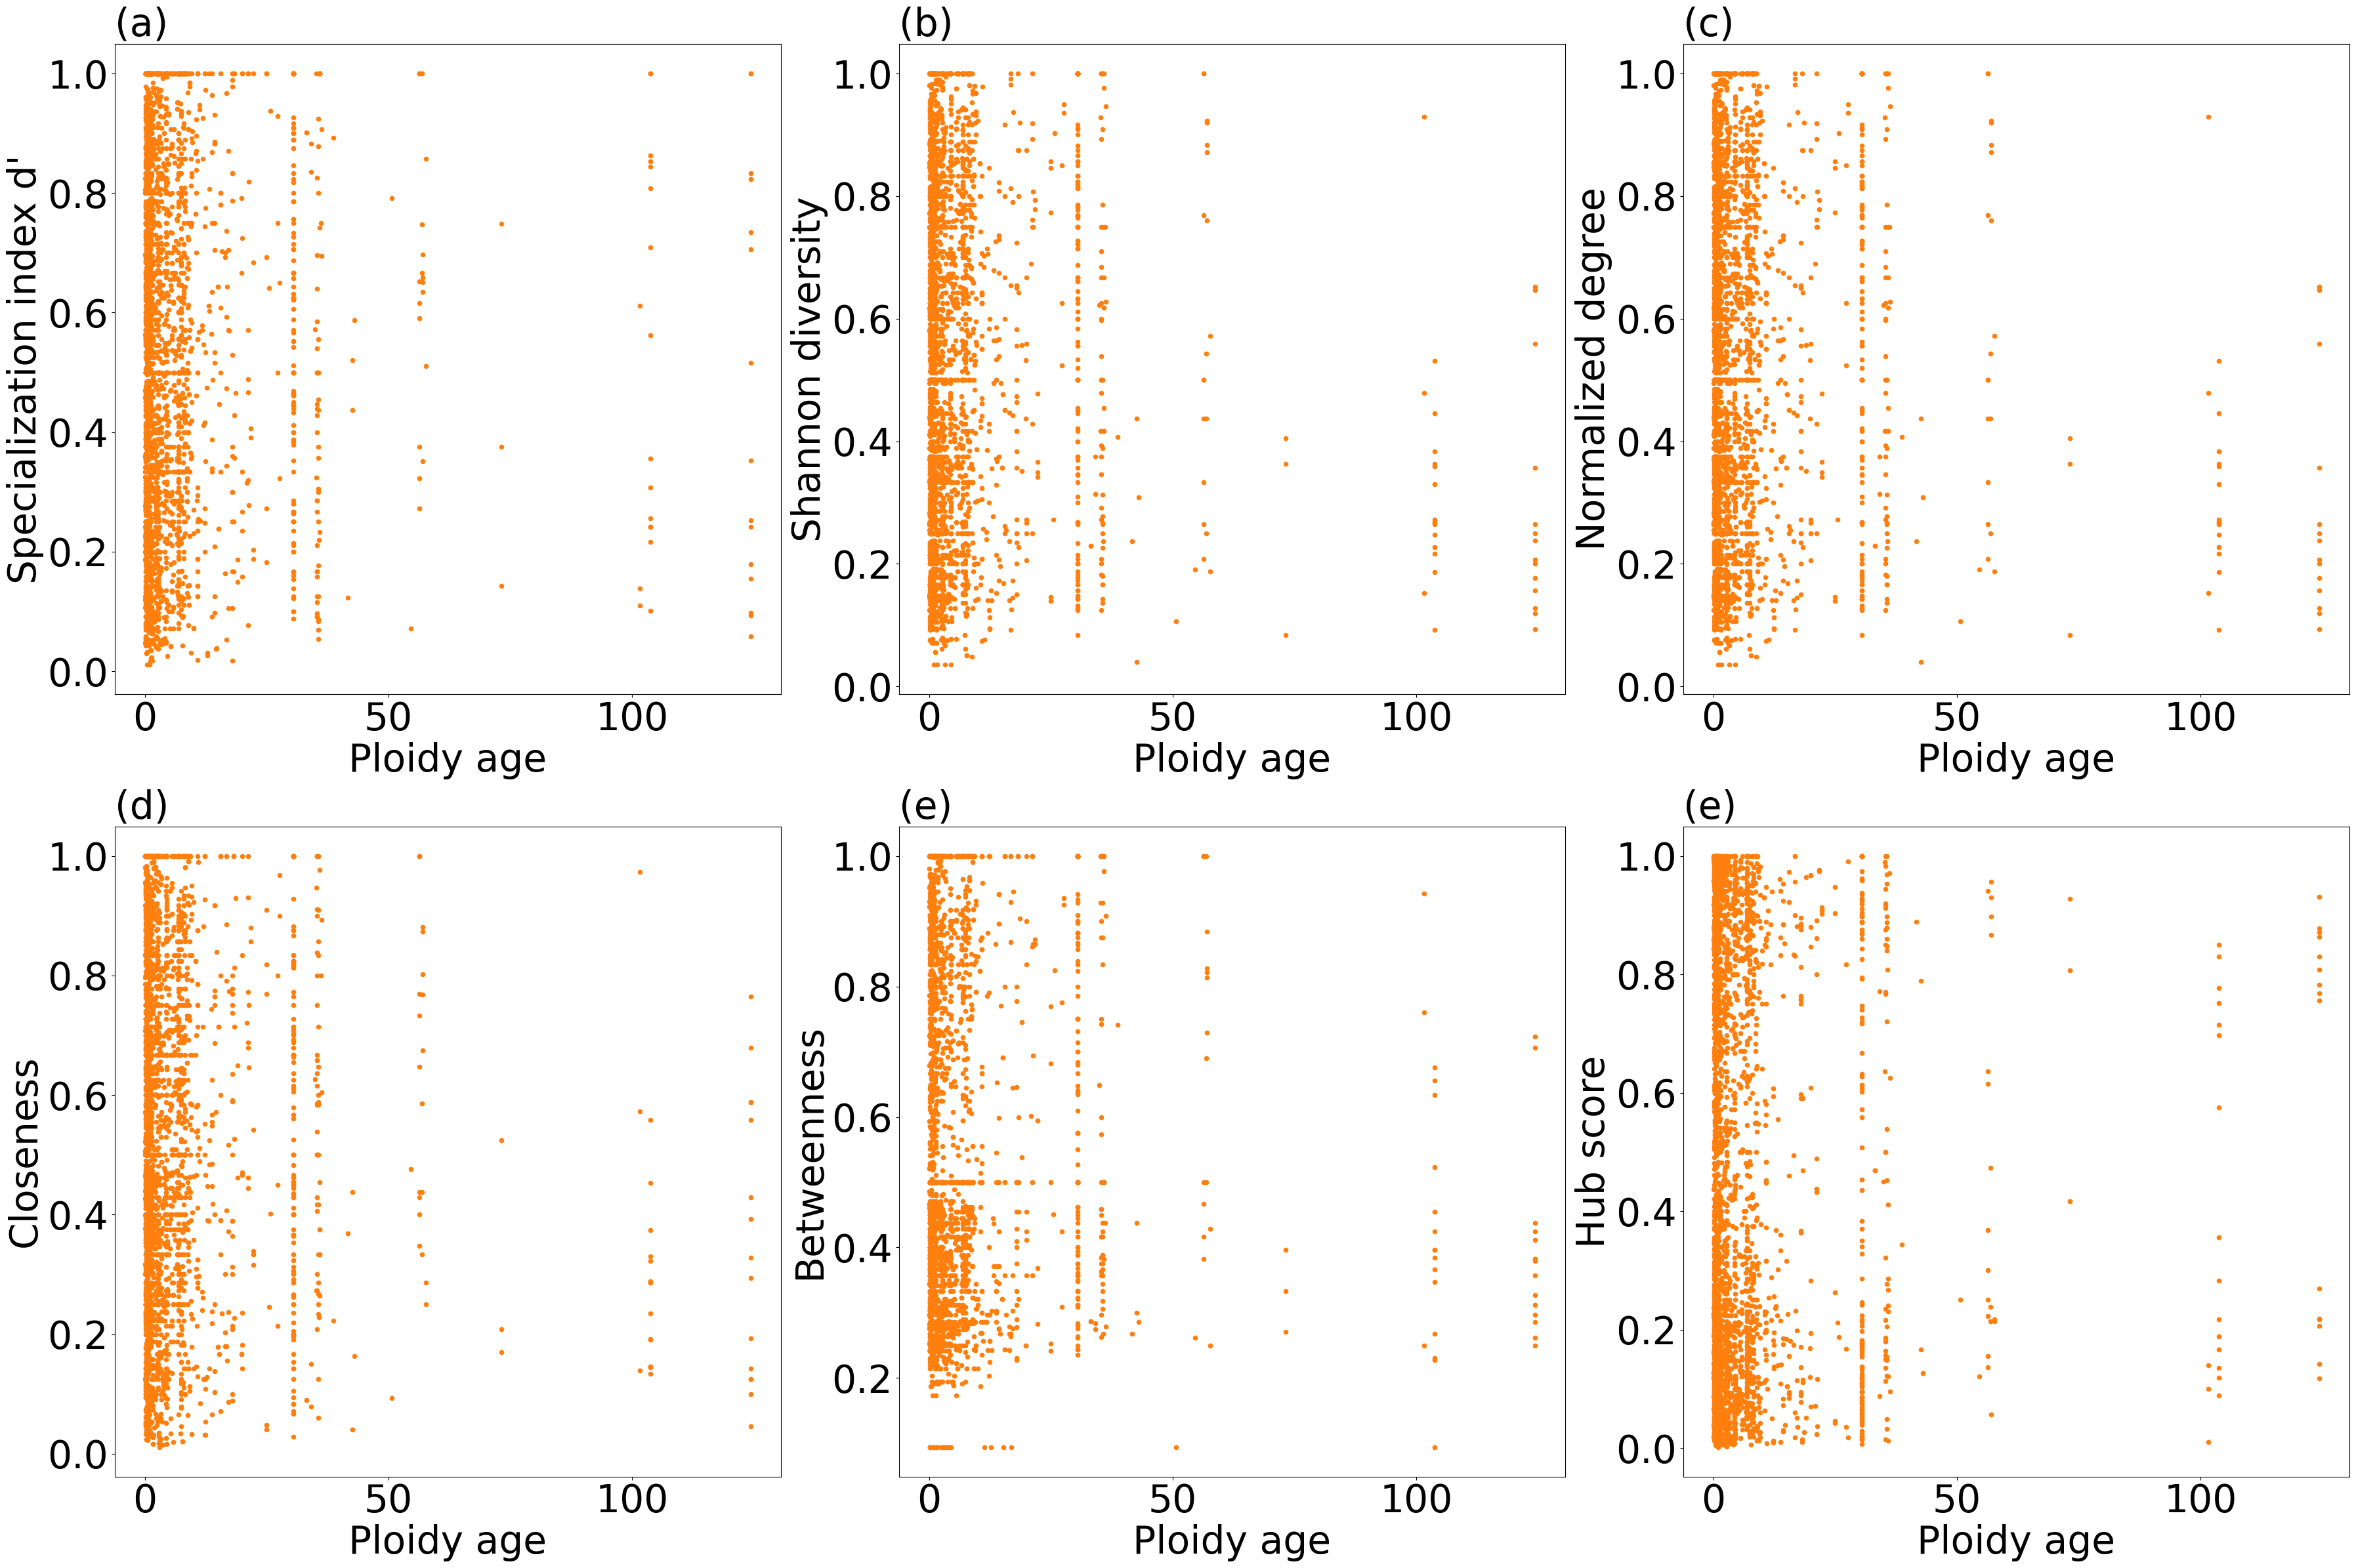

In [47]:
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42
poly_color = "tab:orange"
di_color = "tab:blue"
alpha = 0.4

fig, ax = plt.subplots(figsize=(3*12, 2*12))
polyploids = features_by_ploidy.get_group("Polyploids")

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=fig)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=fig)
ax4 = plt.subplot2grid((2,6), (1,0), colspan=2, fig=fig)
ax5 = plt.subplot2grid((2,6), (1,2), colspan=2, fig=fig)
ax6 = plt.subplot2grid((2,6), (1,4), colspan=2, fig=fig)


polyploids.plot.scatter(x="ploidy_age", y="standardized_d", color=poly_color, ax=ax1)
ax1.set_ylabel("Specialization index d'", fontsize=fontsize)
ax1.set_xlabel("Ploidy age", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.set_title("(a)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_partner.diversity", color=poly_color, ax=ax2)
ax2.set_ylabel("Shannon diversity", fontsize=fontsize)
ax2.set_xlabel("Ploidy age", fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.set_title("(b)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_normalised.degree", color=poly_color, ax=ax3)
ax3.set_ylabel("Normalized degree", fontsize=fontsize)
ax3.set_xlabel("Ploidy age", fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)
ax3.set_title("(c)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_weighted.closeness", color=poly_color, ax=ax4)
ax4.set_ylabel("Closeness", fontsize=fontsize)
ax4.set_xlabel("Ploidy age", fontsize=fontsize)
ax4.tick_params(axis='both', which='major', labelsize=fontsize)
ax4.set_title("(d)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_weighted.betweenness", color=poly_color, ax=ax5)
ax5.set_ylabel("Betweenness", fontsize=fontsize)
ax5.set_xlabel("Ploidy age", fontsize=fontsize)
ax5.tick_params(axis='both', which='major', labelsize=fontsize)
ax5.set_title("(e)", loc="left", fontsize=fontsize)


polyploids.plot.scatter(x="ploidy_age", y="standardized_hubbiness_score", color=poly_color, ax=ax6)
ax6.set_ylabel("Hub score", fontsize=fontsize)
ax6.set_xlabel("Ploidy age", fontsize=fontsize)
ax6.tick_params(axis='both', which='major', labelsize=fontsize)
ax6.set_title("(e)", loc="left", fontsize=fontsize)


fig.tight_layout()
fig.savefig(f"../../../data/figures/fig_pl_age_{'weighted' if do_weighted else 'binary'}.jpeg")

In [48]:
from scipy.stats import ks_2samp

for feature in relevant_features:
    if "standardized" in feature:
        continue
    dres = ks_2samp(features_by_ploidy.get_group("Diploids")[feature], features_by_ploidy.get_group("Polyploids")[feature])
    if dres.pvalue <= 0.05:
        print(f"# KS test for comparison of {feature} distribution across diploids and polyploids = {dres}")

# KS test for comparison of normalised.degree distribution across diploids and polyploids = KstestResult(statistic=0.05950090675100851, pvalue=9.20792371767188e-06)
# KS test for comparison of weighted.closeness distribution across diploids and polyploids = KstestResult(statistic=0.06313486858943934, pvalue=1.965135097525964e-06)


# add network-level metadata when available

In [96]:
final_features_with_classification = pd.read_csv(processed_data_path)
networks_metadata = pd.read_csv(networks_metadata_path)
final_features_with_classification = final_features_with_classification[["network_type", "network_index"] + list(set(final_features_with_classification.columns)-set(networks_metadata.columns))]

In [97]:
final_features_with_classification = final_features_with_classification.merge(networks_metadata, on=["network_type", "network_index"], how="left")
final_features_with_classification = final_features_with_classification[[c for c in final_features_with_classification.columns if "Unnamed" not in c]]
final_features_with_classification = final_features_with_classification.drop_duplicates(subset=["original_name", "network_id"])
final_features_with_classification.notna().sum() / final_features_with_classification.shape[0]

network_type                         1.000000
network_index                        1.000000
resolved_name                        0.990246
standardized_partner.diversity       1.000000
standardized_weighted.betweenness    1.000000
                                       ...   
num_plants                           1.000000
num_resolved                         1.000000
num_classified                       1.000000
num_polyploids                       1.000000
num_diploids                         1.000000
Length: 148, dtype: float64

In [98]:
final_features_with_classification.loc[final_features_with_classification.species_richness%1 != 0, "species_richness"] = final_features_with_classification.species_richness.apply(lambda x: np.exp(x)-1)
final_features_with_classification.to_csv(processed_data_path, index=False)

# add species metadata

In [99]:
plant_trait_db = pd.read_csv(plant_trait_db_path)
final_features_with_classification = final_features_with_classification.merge(plant_trait_db, left_on="Plant", right_on="original_name", how="left")
final_features_with_classification.to_csv(processed_data_path, index=False)

# plot indices distrbiution across subgroups of covariates categories

In [3]:
df = pd.read_csv(processed_data_path)
df["is_polyploid"] = df.is_polyploid.replace({0: "Diploids", 1: "Polyploids"})
df.has_ploidy_variability.fillna(False)
df.has_ploidy_variability = df.has_ploidy_variability.astype(np.float64)
full_dataset = df
rel_cols = ["network_index", "has_ploidy_variability", "Lifeform"] + [c for c in df.columns if "flw_" in c]
limited_dataset = df.dropna(subset=rel_cols) # "flw_len_mean",
limited_dataset.mating_system = limited_dataset.mating_system.replace({"unknown": np.nan})
limited_dataset = limited_dataset.rename(columns={"is_polyploid": "Ploidy level"}).dropna(subset=["mating_system"])
limited_dataset.mating_system = limited_dataset.mating_system.replace({"partially_SC":"SC"})
print(f"# samples in full dataset = {full_dataset.shape[0]:,}")
print(f"# samples in reduced dataset = {limited_dataset.shape[0]:,}")

# samples in full dataset = 4,429
# samples in reduced dataset = 1,353


/var/tmp/pbs.2249254.power9.tau.ac.il/ipykernel_466424/4123837082.py:1: DtypeWarning: Columns (45,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(processed_data_path)
/var/tmp/pbs.2249254.power9.tau.ac.il/ipykernel_466424/4123837082.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_dataset.mating_system = limited_dataset.mating_system.replace({"unknown": np.nan})


In [5]:
df.Lifeform = df.Lifeform.replace({"unclassifiedherb": np.nan, "unclassifiedperennial": np.nan})
df[rel_cols].notna().sum()

network_index                    4429
has_ploidy_variability           4429
Lifeform                         4235
frac_missing_flw_rest            4429
frac_flw_rest                    4429
flw_symmetry_AST_head_level      4300
flw_len_max_AST_head_level       3289
flw_len_min_AST_head_level       3284
flw_color                        4305
flw_shape_AST_floret_level       3301
flw_shape_AST_head_level         4311
flw_len_max_AST_floret_level     3261
flw_len_min_AST_floret_level     3256
flw_len_mean_AST_head_level      3796
n_flw_infl_AST_floret_level      4311
n_flw_infl_AST_head_level        4311
flw_symmetry_AST_floret_level    4300
flw_len_mean_AST_floret_level    3771
dtype: int64

In [6]:
df = limited_dataset
df.has_ploidy_variability = df.has_ploidy_variability.astype(bool) 

/tmp/ipykernel_11870/4145142102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.has_ploidy_variability = df.has_ploidy_variability.astype(bool)


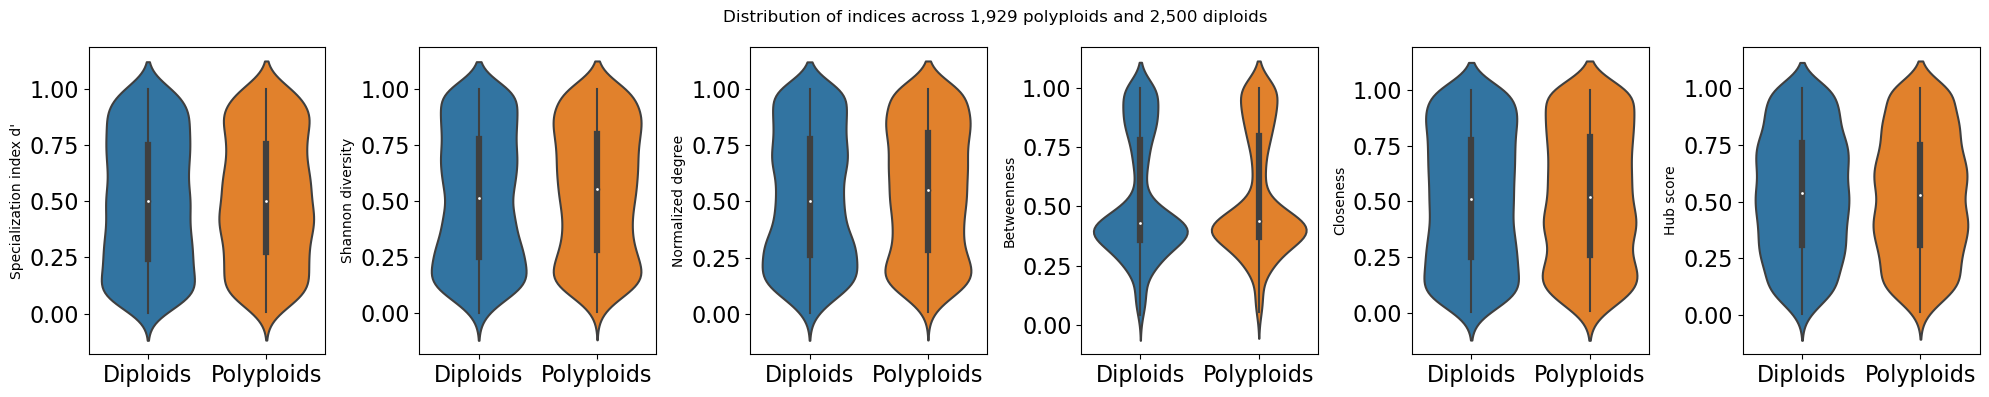

In [7]:
feature_col_to_name = {"standardized_d": "Specialization index d'",
                       "standardized_partner.diversity": "Shannon diversity",
                       "standardized_normalised.degree": "Normalized degree",
                       "standardized_weighted.betweenness": "Betweenness",
                       "standardized_weighted.closeness": "Closeness",
                       "standardized_hubbiness_score": "Hub score"}
features = ["standardized_d", "standardized_partner.diversity", "standardized_normalised.degree",
            "standardized_weighted.betweenness", "standardized_weighted.closeness", "standardized_hubbiness_score"]

fig, ax = plt.subplots(nrows=1, ncols=len(feature_col_to_name), figsize=(20,4))
i = 0
for feat in features:
    sns.violinplot(data=full_dataset, x="is_polyploid", y=feat, ax=ax[i])
    ax[i].set_ylabel(feature_col_to_name[feat])
    ax[i].set_xlabel("")
    i += 1

fig.suptitle(f"Distribution of indices across {full_dataset.loc[full_dataset.is_polyploid == 'Polyploids'].shape[0]:,} polyploids and {full_dataset.loc[full_dataset.is_polyploid == 'Diploids'].shape[0]:,} diploids")
fig.tight_layout()
fig.savefig("../../../data/figures/distribution_of_indices_baseline_full_dataset.jpeg")

In [8]:
def plot_hist_dist_across_var_cat(df: pd.DataFrame, varname: str, outpath: str):
    if varname == "":
        cat = ["all"]
    else:
        subdf = df.dropna(subset=[varname])
        try:
            df[varname].astype(int)
        except Exception as e:
            print(e)
            subdf = subdf.loc[~subdf[varname].str.contains("class")]
        cat = subdf[varname].unique().tolist()
    
    fig, ax = plt.subplots(nrows=len(cat), ncols=len(feature_col_to_name), figsize=(20,4*len(cat)))

    i, j = 0, 0
    for c in cat:
        for feat in features:
            if c == "all":
                data = df
                a = ax[j]
            else:
                data = df.loc[df[varname] == c]
                a = ax[i][j]
            npoly = data.loc[data.is_polyploid == "Polyploids"].shape[0]
            ndi = data.loc[data.is_polyploid == "Diploids"].shape[0]
            
            data.groupby(['is_polyploid'])[feat].plot.hist(alpha=0.5,  ax=a, density=True, stacked=True, legend=(j==len(features)-1))
            a.set_xlabel(feature_col_to_name[feat])
            a.set_ylabel("Freuqency")
            if varname != "":
                a.set_title(f"{varname}={c}\n({npoly:,} polyploids, {ndi:,} diploids)")
            else:
                a.set_title(f"({npoly:,} polyploids, {ndi:,} diploids)")
             
            j += 1
        i += 1
        j = 0
                                
    nsamples = df.shape[0]
    if varname != "":
        nsamples = df.dropna(subset=[varname]).shape[0]
    fig.suptitle(f"Distribution of indices across {nsamples:,} polyploids and diploids" + (f" in different {varname} cateogories\n" if varname != "" else ""), fontsize=14)
    fig.tight_layout()
    fig.savefig(outpath)

# plot Figs 3,4,5 - distributions and interaction plots across plant traits and indices of interest

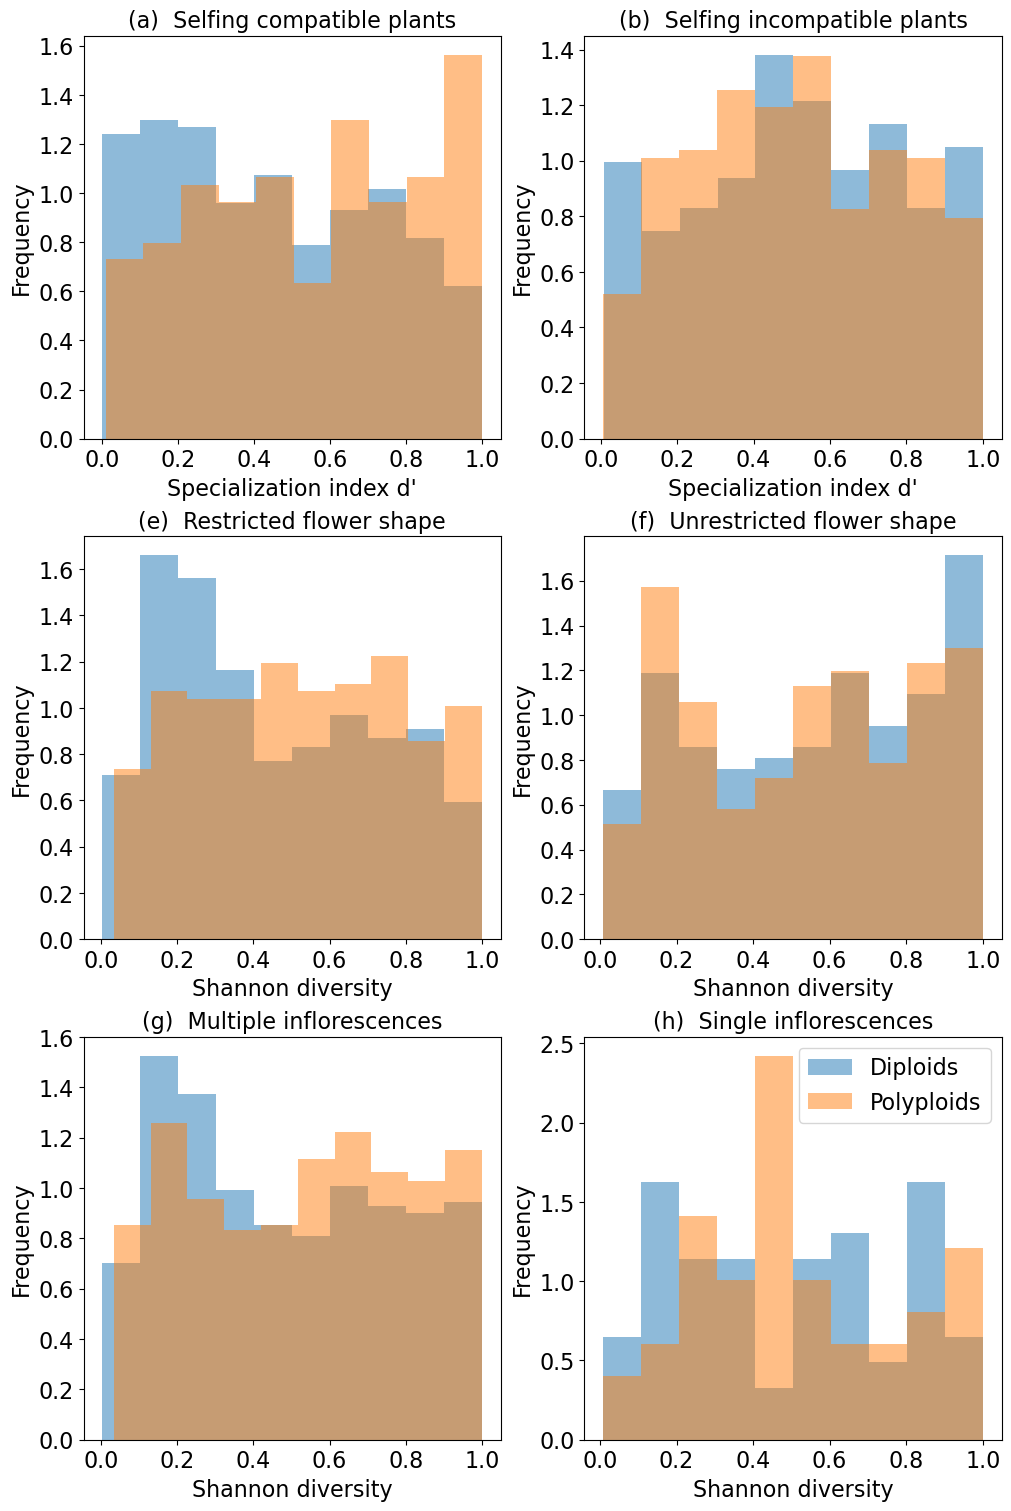

In [4]:
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 16
plt.rc('legend',fontsize=fontsize)
plt.rc('xtick', labelsize=fontsize) 
plt.rc('ytick', labelsize=fontsize) 
poly_color = "tab:orange"
di_color = "tab:blue"
alpha = 0.4

fig, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True, figsize=(10, 15))

# specialization index d' - axes[0]
# flower shape - axes[0][0]-axes[0][1]
limited_dataset.loc[limited_dataset.mating_system != "SI"].groupby(['Ploidy level'])["standardized_d"].plot.hist(alpha=0.5,  ax=axes[0][0], density=True, stacked=True, legend=False)
axes[0][0].set_xlabel("Specialization index d'", fontsize=fontsize)
axes[0][0].set_ylabel("Frequency", fontsize=fontsize)
axes[0][0].set_title("(a)  Selfing compatible plants", fontsize=fontsize)

limited_dataset.loc[limited_dataset.mating_system == "SI"].groupby(['Ploidy level'])["standardized_d"].plot.hist(alpha=0.5,  ax=axes[0][1], density=True, stacked=True, legend=False)
axes[0][1].set_xlabel("Specialization index d'", fontsize=fontsize)
axes[0][1].set_ylabel("Frequency", fontsize=fontsize)
axes[0][1].set_title("(b)  Selfing incompatible plants", fontsize=fontsize)

# shannon diversity - axes[1]
# flower shape - axes[1][0]-axes[1][1]
limited_dataset.loc[limited_dataset.flw_shape_AST_head_level == "restrictive"].groupby(['Ploidy level'])["standardized_partner.diversity"].plot.hist(alpha=0.5,  ax=axes[1][0], density=True, stacked=True, legend=False)
axes[1][0].set_xlabel("Shannon diversity", fontsize=fontsize)
axes[1][0].set_ylabel("Frequency", fontsize=fontsize)
axes[1][0].set_title("(e)  Restricted flower shape", fontsize=fontsize)

limited_dataset.loc[limited_dataset.flw_shape_AST_head_level == "unrestrictive"].groupby(['Ploidy level'])["standardized_partner.diversity"].plot.hist(alpha=0.5,  ax=axes[1][1], density=True, stacked=True, legend=False)
axes[1][1].set_xlabel("Shannon diversity", fontsize=fontsize)
axes[1][1].set_ylabel("Frequency", fontsize=fontsize)
axes[1][1].set_title("(f)  Unrestricted flower shape", fontsize=fontsize)

# # flowers - axes[1][2]-axes[1][3]
limited_dataset.loc[limited_dataset.n_flw_infl_AST_head_level == "multiple"].groupby(['Ploidy level'])["standardized_partner.diversity"].plot.hist(alpha=0.5,  ax=axes[2][0], density=True, stacked=True, legend=False)
axes[2][0].set_xlabel("Shannon diversity", fontsize=fontsize)
axes[2][0].set_ylabel("Frequency", fontsize=fontsize)
axes[2][0].set_title("(g)  Multiple inflorescences", fontsize=fontsize)

limited_dataset.loc[limited_dataset.n_flw_infl_AST_head_level == "single"].groupby(['Ploidy level'])["standardized_partner.diversity"].plot.hist(alpha=0.5,  ax=axes[2][1], density=True, stacked=True, legend=True)
axes[2][1].set_xlabel("Shannon diversity", fontsize=fontsize)
axes[2][1].set_ylabel("Frequency", fontsize=fontsize)
axes[2][1].set_title("(h)  Single inflorescences", fontsize=fontsize)

fig.savefig("../../../data/figures/fig3.svg")

<Figure size 800x600 with 0 Axes>

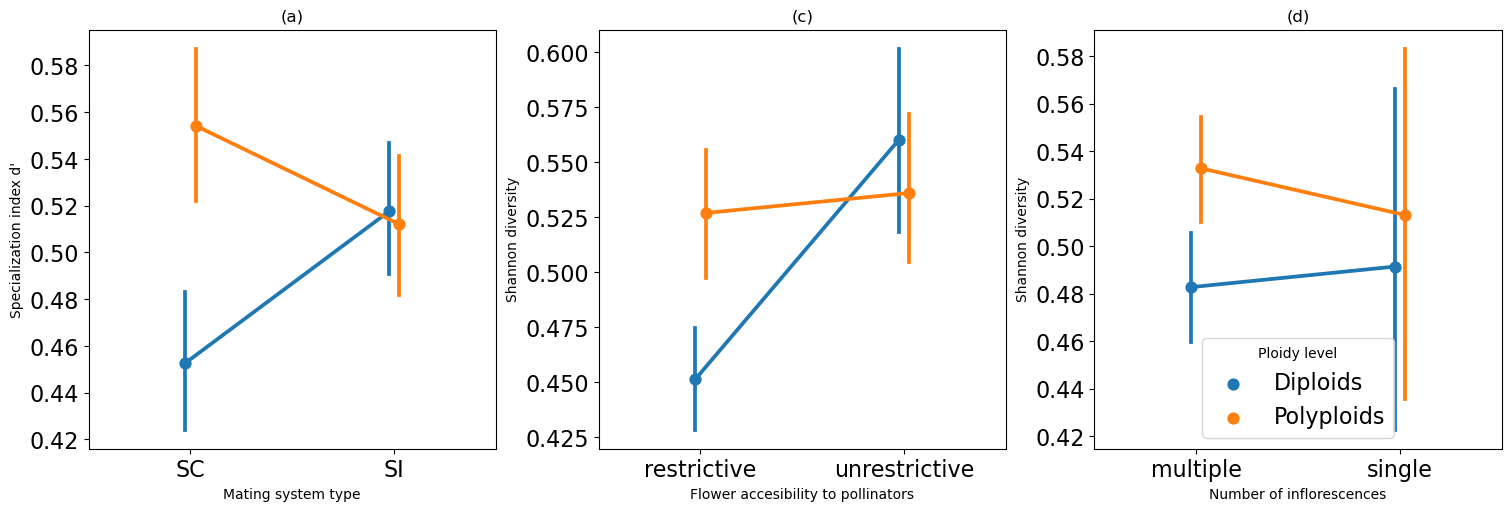

In [6]:
# Create an interaction plot using Seaborn
plt.figure(figsize=(8, 6))

fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(3*5, 5))

sns.pointplot(x="mating_system", y="standardized_d", hue="Ploidy level", data=limited_dataset, dodge=True, ax=axes[0])
axes[0].set_title("(a)")
axes[0].set_xlabel("Mating system type")
axes[0].set_ylabel("Specialization index d'")
axes[0].legend([],[], frameon=False)

sns.pointplot(x="flw_shape_AST_head_level", y="standardized_partner.diversity", hue="Ploidy level", data=limited_dataset, dodge=True, ax=axes[1])
axes[1].set_title("(c)")
axes[1].set_xlabel("Flower accesibility to pollinators")
axes[1].set_ylabel("Shannon diversity")
axes[1].legend([],[], frameon=False)

sns.pointplot(x="n_flw_infl_AST_head_level", y="standardized_partner.diversity", hue="Ploidy level", data=limited_dataset, dodge=True, ax=axes[2])
axes[2].set_title("(d)")
axes[2].set_xlabel("Number of inflorescences")
axes[2].set_ylabel("Shannon diversity")

fig.savefig("../../../data/figures/fig4.svg")

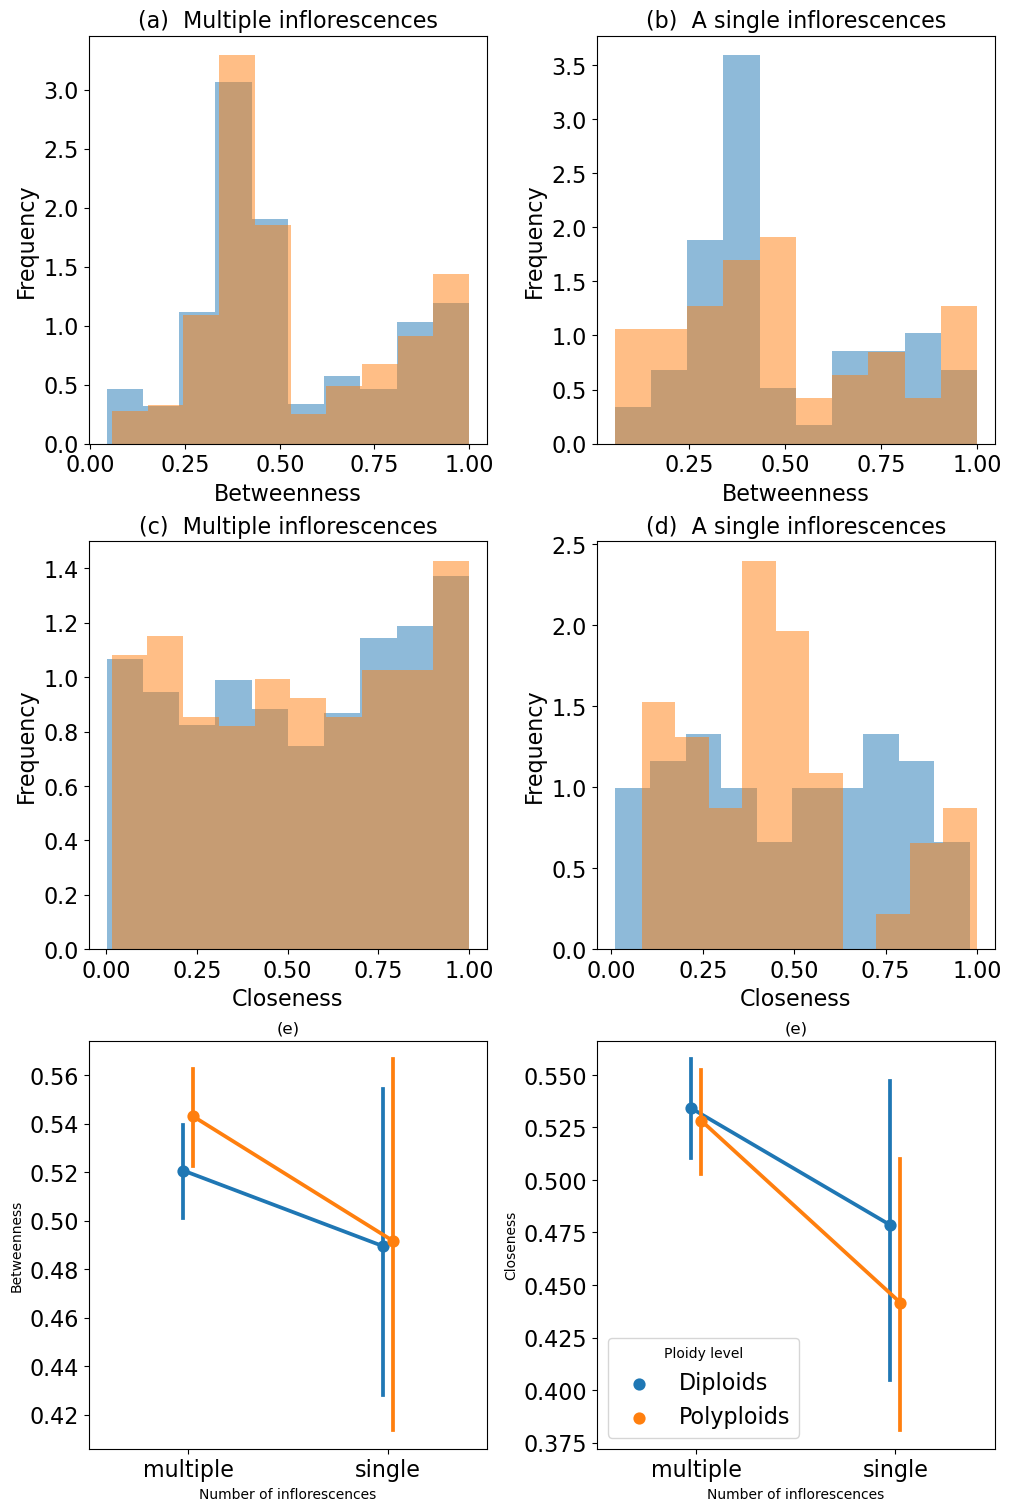

In [7]:
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 16
plt.rc('legend',fontsize=fontsize)
plt.rc('xtick', labelsize=fontsize) 
plt.rc('ytick', labelsize=fontsize) 
poly_color = "tab:orange"
di_color = "tab:blue"
alpha = 0.4

fig, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True, figsize=(10, 15))

# specialization index d' - axes[0]
# flower shape - axes[0][0]-axes[0][1]
limited_dataset.loc[limited_dataset.n_flw_infl_AST_head_level == "multiple"].groupby(['Ploidy level'])["standardized_weighted.betweenness"].plot.hist(alpha=0.5,  ax=axes[0][0], density=True, stacked=True, legend=False)
axes[0][0].set_xlabel("Betweenness", fontsize=fontsize)
axes[0][0].set_ylabel("Frequency", fontsize=fontsize)
axes[0][0].set_title("(a)  Multiple inflorescences", fontsize=fontsize)

limited_dataset.loc[limited_dataset.n_flw_infl_AST_head_level == "single"].groupby(['Ploidy level'])["standardized_weighted.betweenness"].plot.hist(alpha=0.5,  ax=axes[0][1], density=True, stacked=True, legend=False)
axes[0][1].set_xlabel("Betweenness", fontsize=fontsize)
axes[0][1].set_ylabel("Frequency", fontsize=fontsize)
axes[0][1].set_title("(b)  A single inflorescences", fontsize=fontsize)

limited_dataset.loc[limited_dataset.n_flw_infl_AST_head_level == "multiple"].groupby(['Ploidy level'])["standardized_weighted.closeness"].plot.hist(alpha=0.5,  ax=axes[1][0], density=True, stacked=True, legend=False)
axes[1][0].set_xlabel("Closeness", fontsize=fontsize)
axes[1][0].set_ylabel("Frequency", fontsize=fontsize)
axes[1][0].set_title("(c)  Multiple inflorescences", fontsize=fontsize)

limited_dataset.loc[limited_dataset.n_flw_infl_AST_head_level == "single"].groupby(['Ploidy level'])["standardized_weighted.closeness"].plot.hist(alpha=0.5,  ax=axes[1][1], density=True, stacked=True, legend=False)
axes[1][1].set_xlabel("Closeness", fontsize=fontsize)
axes[1][1].set_ylabel("Frequency", fontsize=fontsize)
axes[1][1].set_title("(d)  A single inflorescences", fontsize=fontsize)

sns.pointplot(x="n_flw_infl_AST_head_level", y="standardized_weighted.betweenness", hue="Ploidy level", data=limited_dataset, dodge=True, ax=axes[2][0])
axes[2][0].set_title("(e)")
axes[2][0].set_xlabel("Number of inflorescences")
axes[2][0].set_ylabel("Betweenness")
axes[2][0].legend([],[], frameon=False)

sns.pointplot(x="n_flw_infl_AST_head_level", y="standardized_weighted.closeness", hue="Ploidy level", data=limited_dataset, dodge=True, ax=axes[2][1])
axes[2][1].set_title("(e)")
axes[2][1].set_xlabel("Number of inflorescences")
axes[2][1].set_ylabel("Closeness")

fig.savefig("../../../data/figures/fig5.svg")

# debug the inconsistencies between the full dataset and the limited dataset

In [116]:
full_dataset["in_limited"] = full_dataset.apply(lambda rec: pd.notna(rec.has_ploidy_variability) and
                                                pd.notna(rec.Lifeform) and
                                                pd.notna(rec.flw_color) and
                                                pd.notna(rec.flw_shape), axis=1)

In [117]:
debug = full_dataset.loc[full_dataset.in_limited == False]

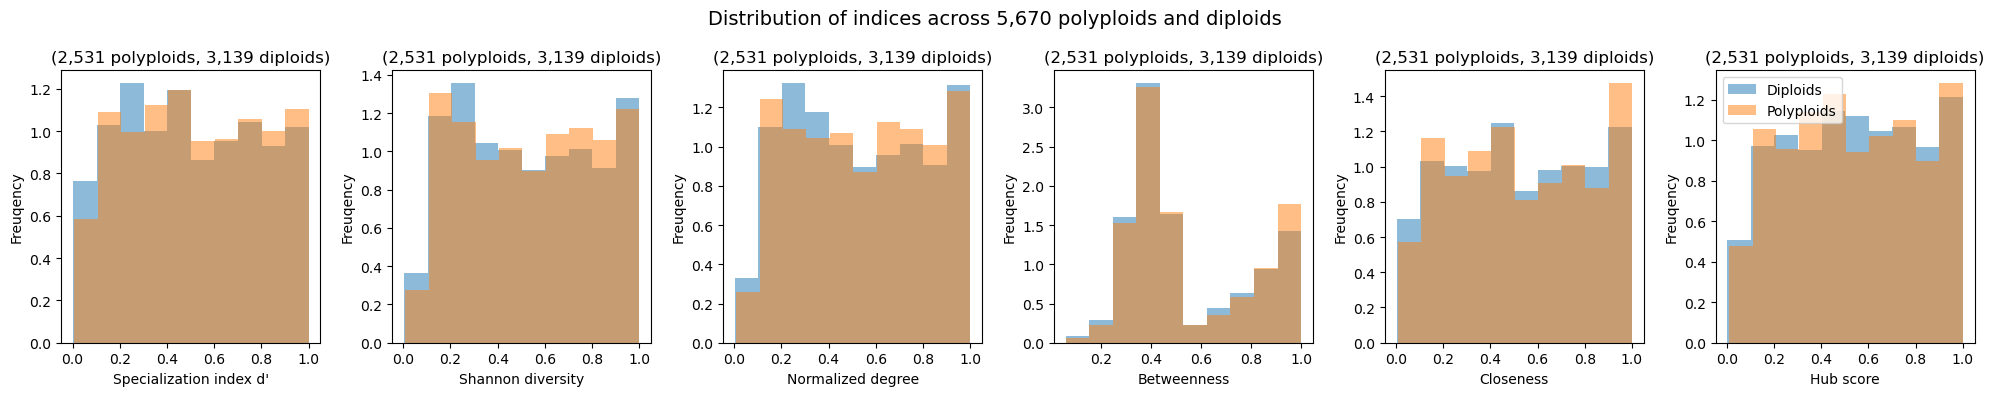

In [118]:
plot_hist_dist_across_var_cat(df=full_dataset, varname="", outpath="../../../data/figures/spec_across_full_data.jpeg")

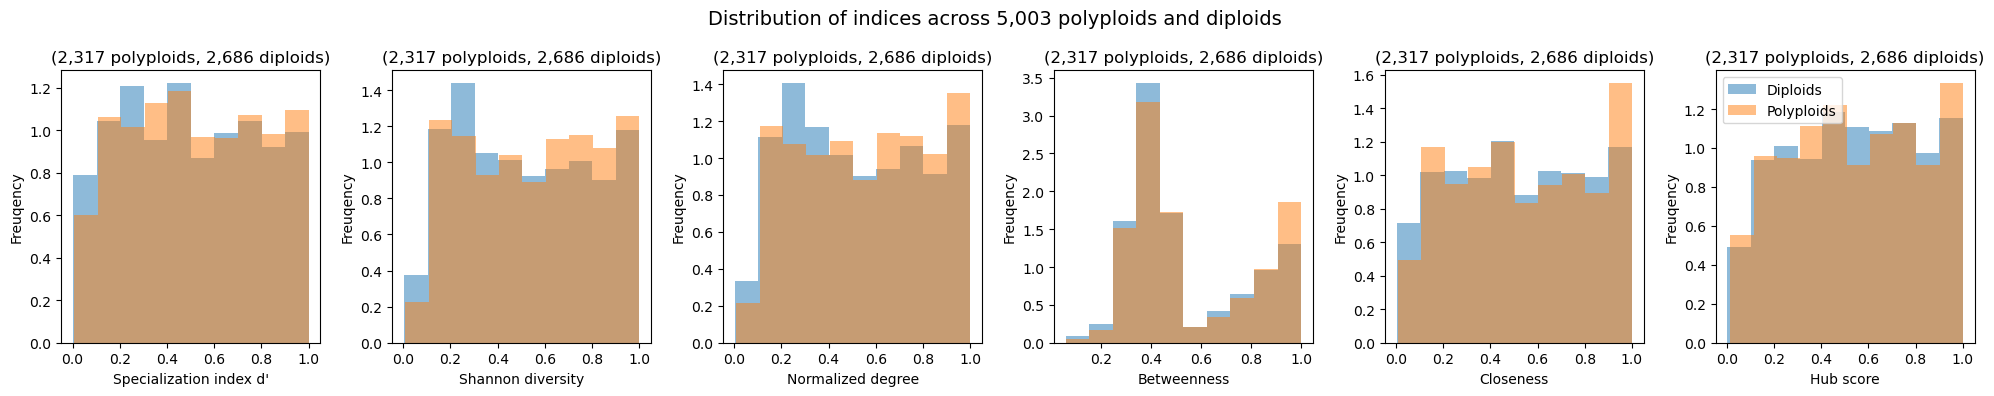

In [119]:
plot_hist_dist_across_var_cat(df=limited_dataset, varname="", outpath="../../../data/figures/spec_across_limited_data.jpeg")

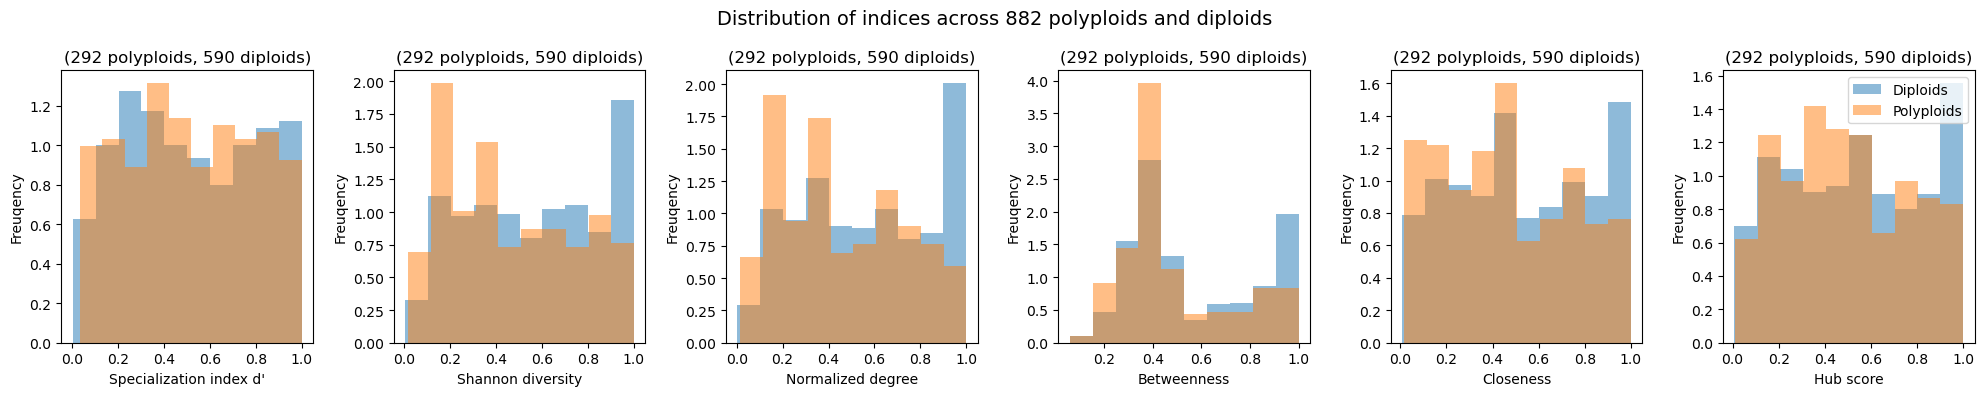

In [120]:
plot_hist_dist_across_var_cat(df=debug, varname="", outpath="../../../data/figures/spec_across_missing_data.jpeg")

In [121]:
full_dataset.loc[full_dataset['standardized_partner.diversity'] == 1].groupby("is_polyploid").Plant.count()

is_polyploid
Diploids      207
Polyploids    183
Name: Plant, dtype: int64

In [122]:
limited_dataset.loc[limited_dataset['standardized_partner.diversity'] == 1].groupby("is_polyploid").Plant.count()

is_polyploid
Diploids      158
Polyploids    178
Name: Plant, dtype: int64

In [123]:
limited_dataset.groupby("is_polyploid").Plant.count() / limited_dataset.shape[0]

is_polyploid
Diploids      0.536878
Polyploids    0.463122
Name: Plant, dtype: float64

In [124]:
full_dataset.groupby("is_polyploid").Plant.count() / full_dataset.shape[0]

is_polyploid
Diploids      0.553616
Polyploids    0.446384
Name: Plant, dtype: float64

# report available samples per meta feature

In [183]:
final_features_with_classification = pd.read_csv(processed_data_path)
cols = ['is_polyploid','ploidy_age','has_ploidy_variability',
        'mating_system','LifeCycle','Growth_form','Lifeform'] + [c for c in final_features_with_classification.columns if c.startswith("flw_")] + list(networks_metadata_rel_cols)
stats_report = final_features_with_classification[cols].notna().sum().reset_index().rename(columns={"index": "variable", 0:"n_samples"})

/var/tmp/pbs.2194328.power9.tau.ac.il/ipykernel_117182/1271187251.py:1: DtypeWarning: Columns (4,33,40,73,88,92,107,122) have mixed types. Specify dtype option on import or set low_memory=False.
  final_features_with_classification = pd.read_csv(processed_data_path)


In [90]:
desc = {'is_polyploid': "binary ploidy level (0-diploid, 1-polyploid",
                                                     'ploidy_age': "inferred ploidy age from ploidb pipeline. for diplods with no age, age data was complemented based on ancient events inferred by the 1KP project",
                                                     'has_ploidy_variability': "flag indicating whether the taxon exhibits both diploid and polyploid individuals, inferred based on variablity in chromosome numbers exceeding 1.5*minimial reported number",
                                                     'mating_system': "type of mating sytem - sc (selfing compatible), si (selfing incompatible) or partially sc",
                                                     "flw_symmetry": "Symmetry of the corolla: zygomorphic; actinomorphic; asymmetric; no_corolla",
                                                     "flw_shape": "Whether the shape of the flower restricts pollinator accessibility to floral rewards or not: restrictive; unrestrictive",
                                                     "flw_color": "Visual spectra and predominant color of the corolla or color of the bracts or sepals when they are the predominant color for attraction (e.g., Bromeliads, Castilleja linariaefolia). When there is no predominant color (e.g. orchid flowers with yellow, purple, white, etc) define as multiple. Categories: White (cream), Purple, Blue, Green, Yellow, Orange, Red, Pink, Brown, Multiple",
                                                     "flw_len_mean": "Mean value of the linear length (mm) of the attractive unit of flower (e.g. corolla). Data calculated from 5 measured flowers (using digitized herbarium sheets) OR the sum between flw_len_min and flw_len_max divided by 2",
                                                     "num_of_flw_infl": "Number of flowers per inflorescence. Categories: single; multiple",
                                                     "LifeCycle": "the life cycle of the taxon: perennial, annual or mixed. In case of conflicting reports of a sole life cycle, the value is set as 'conflict'",
                                                     "Growth_form": "the growth form of the taxon: woody, herb or mixed. In case of conflicting reports of a sole life cycle, the value is set as 'conflict'",
                                                     "Lifeform": "the life form of the taxon: woody, annual or perrenial herb. In case of mixed life cycle, we define it as 'mixed_herb', and in case of mixed gowrg form, we define it as 'perennial_mixed'. in case of uclassified life form or growth form, we define it as 'unclassified_herb' or 'unclassified_perennial' respectively",
                                                     "Altitude": "the mean distance above sea level across the ecoregion area",
                                                     'Difference in glaciers': "The extent of de-glaciation since the LGM was estimated by comparing the present ice coverage of each ecoregion75 to that inferred for the LGM76. The result is expressed as the percentage of de-glaciation per ecoregion. When both past and present glaciation extents were missing, the ecoregion was discarded from this analysis. Therefore, this attribute was examined for the 207 ecoregions that had some ice coverage data but not across all ecoregions.",\
                                                     'Current glaciers': "estimated coverage of glaciers in the respective ecoregion, collected in 2019",
                                                     'LGM glaciers': "estimated coverage of glaciers in the respective ecoregion, 22,000 years ago", 
                                                     "species_richness": "regional species richness measured for the respective ecoregion obtained from Kier et al. (https://doi.org/10.1111/j.1365-2699.2005.01272.x)",
                                                     'Climate_PC1': "first PC in PCA on the 19 bioclimate variables. Explains 0.82 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Climate_PC2': "second PC in PCA on the 19 bioclimate variables. Explains 0.74 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Climate_PC3': "third PC in PCA on the 19 bioclimate variables. Explains 0.46 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'ChangeInClimate_PC1': "first PC in PCA on the 19 difference values between biolimate varaibles as measured in 2019 vs. 22,000 years ago. Explains 0.71 for the variablity. For loadings of varaibles see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'ChangeInClimate_PC2': "second PC in PCA on the 19 difference values between biolimate varaibles as measured in 2019 vs. 22,000 years ago. Explains 0.56 for the variablity. For loadings of varaibles see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'ChangeInClimate_PC3': "third PC in PCA on the 19 difference values between biolimate varaibles as measured in 2019 vs. 22,000 years ago. Explains 0.36 for the variablity. For loadings of varaibles see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'highest_pollinator_rank_index': "ordinal values of highest taxonomic ranks of pollinators documented in the network of the sample. 0 corresponds to the highest rank (tribe) and 9 to the lowest (species)",
                                                     'highest_pollinator_rank_name': "categorical values of highest taxonomic ranks of pollinators documented in the network of the sample. ranges from tribe (highest) to species (lowest)",
                                                     'Basal angiosperm %': "% of Basal angiosperm species recorded in the respective ecoregion, based on data from 2019",
                                                     'Asterids %': "% of Asterids species recorded in the respective ecoregion, based on data from 2019",
                                                     'Basal dicots %': "% of Basal dicots species recorded in the respective ecoregion, based on data from 2019",
                                                     'Basal monocots %':"% of Basal monocots species recorded in the respective ecoregion, based on data from 2019",
                                                     'Commelinids %': "% of Commelinids species recorded in the respective ecoregion, based on data from 2019",
                                                     'Rosids %': "% of Rosids species recorded in the respective ecoregion, based on data from 2019",
                                                     'Taxonomy_PC1': "first PC of PCA on the 6 taxonomic composition varaibles across ecoregions. explains 0.76 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Taxonomy_PC2': "second PC of PCA on the 6 taxonomic composition varaibles across ecoregions. explains 0.58 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Taxonomy_PC3': "third PC of PCA on the 6 taxonomic composition varaibles across ecoregions. explains 0.36 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Woody %': "% of woody species recorded in the respective ecoregion, based on data from 2019",
                                                     'Annual %': "% of annual species recorded in the respective ecoregion, based on data from 2019",
                                                     'Perennial herb %': "% of perennial herb species recorded in the respective ecoregion, based on data from 2019",
                                                     'Biome frequency': "first PC of PCA on the 3 lifeform composition varaibles across ecoregions. explains 1 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Lifeform_PC1': "first PC of PCA on the 3 lifeform composition varaibles across ecoregions. explains 1 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Lifeform_PC2': "second PC of PCA on the 3 lifeform composition varaibles across ecoregions. explains 0.99 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Lifeform_PC3': "third PC of PCA on the 3 lifeform composition varaibles across ecoregions. explains 0.73 of the varaiblity. For loadings of variables see supplementary table 6 in https://www.nature.com/articles/s41559-018-0787-9#MOESM1",
                                                     'Polyploid percent': "% of polyploid species recorded in the respective ecoregion, based on data from 2019",
                                                     'Human footprint': "As a measure for anthropogenic disturbance of ecosystems (that is, the amount of land or sea necessary to support the consumption of local human activity, including population density, land transformation, accessibility and electrical power infrastructure), we used a data layer assembled by Sanderson et al.86." ,
                                                     'Elevation amplitude': "the difference between the 90th and 10th percentiles of altitude across the ercoregion area" ,
                                                     'Binomial PV': " the significance of the Binomial test comparing the ecoregions frequency to its surrounding biome",
                                                     'NPP': "net primary productivity, as estimated by Imhoff et al. (https://www.nature.com/articles/nature02619)",
                                                     'Phosphorus retention': "Phosphorus soil retention potential83 was extracted per ecoregion. This layer comprises 12 levels of phosphorus availability that were converted to a discrete numerical scale."}
stats_report["description"] = stats_report.variable.apply(lambda v: desc.get(v, np.nan))

In [91]:
stats_report.to_csv(f"variables_to_n_samples_{'un' if do_weighted==False else ''}weighted.csv")

# save species level phylogeny and trait data for phylogenetic signal visualization

In [116]:
df = pd.read_csv(processed_data_path)
df.Plant = df.Plant.str.replace(" ", "_")
df = df.loc[df.included_in_analysis]

/tmp/ipykernel_39262/3739903435.py:1: DtypeWarning: Columns (88,90,108,109,110,112) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(processed_data_path)


In [119]:
cols = ["Plant", "Family", "Genus", "is_polyploid_x", "mating_system", "Growth_form", "LifeCycle", "Lifeform"] + [c for c in df.columns if "flw_" in c]
sp_spec_df = df[[c for c in cols if "network" not in c]].drop_duplicates(["Plant"]).dropna(how="all")
print(f"# unique species = {sp_spec_df.shape[0]:,}")

# unique species = 1,203


In [120]:
allmb_tree = Tree(allmb_tree_path, format=1)
for l in allmb_tree.get_leaves():
    l.name = l.name.lower().replace(" ", "_")
sp_in_tree = set(sp_spec_df.Plant)&set(allmb_tree.get_leaf_names())
len(sp_in_tree)

946

In [121]:
allmb_tree.prune(sp_in_tree, preserve_branch_length=True)
allmb_tree.write(outfile="../../../data/statistical_analysis/species_level/traits_tree.nwk", format=1)

In [122]:
species_metadata_3 = pd.read_excel(species_metadata_path_3, sheet_name="Data")
species_metadata_3.scientificName = species_metadata_3.scientificName.str.lower()
sp_to_fam = species_metadata_3.set_index("scientificName")["family"].to_dict()
sp_spec_df.loc[sp_spec_df.Family.isna(), "Family"] = sp_spec_df.Plant.apply(lambda n: sp_to_fam.get(n.replace("_", " "), np.nan))

/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [123]:
sp_spec_df.LifeCycle = sp_spec_df.LifeCycle.replace({"perennial": "perennial", "Annual":"annual", "annual\xa0": "annual", "perennial\xa0": "perennial"})
sp_spec_df = sp_spec_df.loc[sp_spec_df.Plant.isin(sp_in_tree)]

In [124]:
sp_class = pd.read_csv("../../../data/trees/species_family_classification.csv")
sp_class.Plant = sp_class.Plant.str.replace(" ", "_")
sp_to_fam = sp_class.set_index("Plant")["Family"].to_dict()

In [125]:
sp_spec_df.Family = sp_spec_df.apply(lambda rec: sp_to_fam.get(rec.Plant,np.nan) if pd.notna(sp_to_fam.get(rec.Plant,np.nan)) else rec.Family, axis=1).str.lower()

In [126]:
ast_members_by_me = sp_class.query("Family == 'asteraceae'").Plant.str.replace(" ", "_").tolist()
ast_members_by_spec = sp_spec_df.query("Family == 'asteraceae'").Plant.str.replace(" ", "_").tolist()
sp_spec_df.loc[sp_spec_df.Plant.isin(set(ast_members_by_me)-set(ast_members_by_spec)), "Family"] = "asteraceae"
ast_members_by_spec = sp_spec_df.query("Family == 'asteraceae'").Plant.str.replace(" ", "_").tolist()

In [127]:
sp_spec_df.dropna(subset=["Family"]).loc[sp_spec_df.Family.str.startswith('a', na=False)].groupby("Family").Plant.count()

Family
acanthaceae           5
actinidiaceae         2
alismataceae          2
alstroemeriaceae      1
amaranthaceae         5
amaryllidaceae       13
anacardiaceae         1
apiaceae             25
apocynaceae           6
aquifoliaceae         2
araceae               1
araliaceae            2
asparagaceae         11
asphodelaceae         1
asteraceae          172
Name: Plant, dtype: int64

In [128]:
allmb_tree.check_monophyly(values=ast_members_by_spec, target_attr="name", ignore_missing=True)

(True, 'monophyletic', set())

In [129]:
lca = allmb_tree.get_common_ancestor(list(ast_members_by_spec))
print(f"# leaves under astereceae lca = {len(lca.get_leaves())}")

# leaves under astereceae lca = 172


In [130]:
sp_spec_df.to_csv("../../../data/statistical_analysis/species_level/traits_data_for_phylo_analysis.csv")
allmb_tree.write(outfile="../../../data/statistical_analysis/species_level/traits_tree.csv")